# Ecological Index -  Input dominating index over time
- Calculate historical and future ecological index values from CESM2-LE MARBL NPP, KGP, & FEISTY (demersal only) and penguin population projections (EP and AP).
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- August 2025

In [1]:
import utils
import xarray as xr
import numpy as np
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

## How to make ecoindex

- Verify that time (year) and spatial dimensions (lat/lon) are identical for each input
- Only interested in forced change signal, so calculating and using ensemble mean for CESM2 related inputs.
- Penguin projections are median of the future projected populations.
- Calculate ecoindex by summing all inputs. We've weighted each input equally, but could do sums of just some inputs of value (e.g. MARBL only, FEISTY + MARBL, PENGINS only).
- We'll calculate the index for each year 1950-2099, but there are concerns with noise in penguin projections. Thus, we'll also calculate decadal ecoindex values for 1960 - 2090 by averaging 5 years around the decade (e.g. 1980 --> 1978, 1979, 1980, 1981, 1982)
- Only need CCAMLR MPA regions: 1 (Peninsula), 3 (Weddell), 4 (E Weddell), 7 (E. Ant), 8 (Ross), 9 (Bellingshausen and Amundsen)
- Check and test both global and regional scaling **for the EcoIndex only** (not inputs), so each region should have an ecoindex of 1 that shows the maximum *in that region*. We want to see most valuable regions around whole continent and within regions.  This is relevant because management is done regionally by CCAMLR.
- We use maximum value to scale so that the range is 0-1 for Ecoindex. We also tried scaling by median but that didn't really change where was most valuable, just the scaling, so stick with maximum value for ease of communication.

- We need to mask data that is outside the seasonal SIZ. Thus we are implicitly only considering areas that have sea ice, which is critical for ice-obligate species (e.g. krill)
- We will also mask krill and demersal fish using environmental conditions so that we don't consider biomass outside known temperature thresholds for their habitats. Summer SST for krill and annual mean bottom temperature for demersal fish.


## Load Data

### Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

# load sea ice masks
fin = 'REGION_MASK_gx1v7.nc'
ds_mask = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_mask = ds_mask.isel(time=0)
ds_mask = ds_mask.rename({'lat':'nlat','lon': 'nlon'})
ds_mask['nlat'] = ds_grid.nlat
ds_mask['nlon'] = ds_grid.nlon
ds_mask

<xarray.Dataset>
Dimensions:       (nlon: 320, nlat: 384)
Coordinates:
  * nlon          (nlon) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319
  * nlat          (nlat) int64 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
Data variables: (12/18)
    Lab_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    GIN_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Bar_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ArcOc_mask    (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Sib_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Beau_mask     (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...            ...
    Ross_mask     (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Ind_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Pac_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    BAm_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    nh_mask       (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    sh_mask       (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)
ds_mask = ds_mask.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

In [6]:
# Read in 
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
#ds_ccamlr = ds_ccamlr.rename({'lat':'nlat','lon': 'nlon'})
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

# keep just masks of interest (MPA planning areas, polynya regions, coastal)
ccamlr_in = ['mpa_plan_1','mpa_plan_2', 'mpa_plan_3', 'mpa_plan_4', 'mpa_plan_5', 'mpa_plan_6', 'mpa_plan_7','mpa_plan_8','mpa_plan_9','mpa_plan_1_mod','mpa_plan_3_mod','mpa_plan_4_mod','mpa_plan_3_4','mpa_plan_7_mod']
ccamlr_masks = ds_ccamlr[ccamlr_in]

# now load in the different masks as a new coordinate
ccamlr_masks = xr.concat([ds_ccamlr.mpa_plan_1, ds_ccamlr.mpa_plan_2, ds_ccamlr.mpa_plan_3,
                          ds_ccamlr.mpa_plan_4, ds_ccamlr.mpa_plan_5, ds_ccamlr.mpa_plan_6,
                          ds_ccamlr.mpa_plan_7, ds_ccamlr.mpa_plan_8, ds_ccamlr.mpa_plan_9,
                          ds_ccamlr.mpa_plan_1_mod, ds_ccamlr.mpa_plan_3_mod, ds_ccamlr.mpa_plan_4_mod, 
                          ds_ccamlr.mpa_plan_3_4, ds_ccamlr.mpa_plan_7_mod],
                         dim='region')
ccamlr_masks['region']=ccamlr_in


In [7]:
# Read in Antarctic Geography Shapefiles
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'
file_in = 'USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp'

shdf_ant = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ant = shdf_ant.to_crs(ccrs.SouthPolarStereo())

## Load some Environmental data

In [8]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/environment/'

### Load the CESM2-LE sea ice data
- This is needed to mask the CESM2-LE data so we find maximum **only within the SIZ**
- We want to mask high NPP north of ACC
- Also accounts for ice-obligate species implicitly

In [9]:
# load SIZ
file_in = 'CESM2-LE-SIZ.nc'
ds_siz = xr.open_dataset(path_in+file_in, decode_times=True)

In [10]:
# keep all SIZ data
siz_all = ds_siz.SIZ_SEP

In [11]:
# get ensemble means of SIC for each year to get annual average SIZ
sic_ens_mean = ds_siz.SIC_SEP.mean(dim='member_id')

### Load the CESM2-LE ocean temperature data
- This is needed to mask the CESM2-LE data for habitat suitability so species only exist in known temperature habitat ranges
- Krill only where summer SST <3C
- Demersal Fish only where annual mean bottom temperature are <1C (Toothfish threshold)

In [12]:
# load SST
file_in = 'CESM2-LE-summer-mean-SST.nc'
ds_sst = xr.open_dataset(path_in+file_in, decode_times=True)

In [13]:
ds_sst.time

<xarray.DataArray 'time' (time: 150)>
array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973,
       1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033,
       2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045,
       2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057,
       2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069,
       2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081,
       2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093,
       2094, 2095, 2096, 2097, 2098, 2099])
Coordinates:
  * time     (time) int64 1950 1951 1952 1953 1954 ... 2095 2096 2097 2098 2099

In [14]:
# load TBOT
file_in = 'CESM2-LE-annual-mean-TBOT.nc'
ds_tbot = xr.open_dataset(path_in+file_in, decode_times=True)

# cut final year
ds_tbot = ds_tbot.where(ds_tbot.time < 2100, drop=True)

### Load Net Primary Productivity (NPP) data

In [15]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'

In [16]:
# load NPP
file_in = 'CESM2-LE-seasonal-integrals-NPP.nc'
ds_npp = xr.open_dataset(path_in+file_in, decode_times=True)

# use entire growth season
npp = ds_npp.NPP_ONDJFM

In [17]:
# keep only points in the SIZ by year and member
npp_mask = npp.where(siz_all == 1)

In [18]:
# get ensemble mean
npp_mean = npp_mask.mean(dim='member_id')

# replace missing values with 0
npp_mean = npp_mean.fillna(0)

In [19]:
# scale this yearly data by maximum value in whole domain
data = npp_mean
scale_value = data.max(dim=['nlat','nlon'])
npp_scaled = data/scale_value

# mask to omit land points
npp_scaled = npp_scaled.where(ds_grid.REGION_MASK == 1)

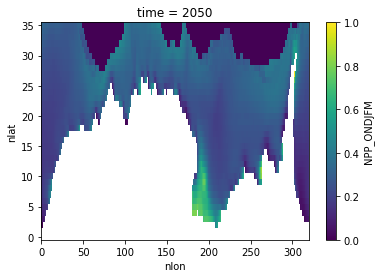

In [20]:
npp_scaled.isel(time=100).plot()

### Load Krill Growth Potential (KGP) data

In [21]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'

In [22]:
# load KGP
file_in = 'CESM2-LE-seasonal-integrals-KGP.nc'
ds_kgp = xr.open_dataset(path_in+file_in, decode_times=True)

# use entire growth season
kgp = ds_kgp.KGP_ONDJFM

# set negative KGP to be zero, then mask land again
kgp = kgp.where(kgp > 0, other=0)
kgp = kgp.where(npp >= 0)

In [23]:
# keep only points in the SIZ by year and member
kgp_mask = kgp.where(siz_all == 1)

In [24]:
# keep only points where summer mean SST is <= 3C by year and member
kgp_mask = kgp_mask.where(ds_sst.SST_ONDJFM <= 3)

In [25]:
# get ensemble mean
kgp_mean = kgp_mask.mean(dim='member_id')

# replace missing values with 0
kgp_mean = kgp_mean.fillna(0)

In [26]:
# scale this yearly data by maximum value in whole domain
data = kgp_mean
scale_value = data.max(dim=['nlat','nlon'])
kgp_scaled = data/scale_value

# mask to omit land points
kgp_scaled = kgp_scaled.where(ds_grid.REGION_MASK == 1)

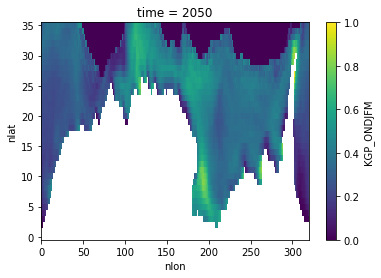

In [27]:
kgp_scaled.isel(time=100).plot()

### Load FEISTY fish data (use demersal fish layer only)

In [28]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'

In [29]:
# load FEISTY
file_in = 'CESM2-LE-annual-mean-FEISTY.nc'
ds_feisty = xr.open_dataset(path_in+file_in, decode_times=True)

# use demersal only
demersal = ds_feisty.Demersal

In [30]:
# cut final year
demersal = demersal.where(demersal.time < 2100, drop=True)

In [31]:
# keep only points in the SIZ by year and member
demersal_mask = demersal.where(siz_all == 1)

In [32]:
# keep only points where annual mean TBOT is <= 1C by year and member
demersal_mask = demersal_mask.where(ds_tbot.TEMP_bottom <= 1)

In [33]:
# get ensemble mean
demersal_mean = demersal_mask.mean(dim='member_id')

# replace missing values with 0
demersal_mean = demersal_mean.fillna(0)

In [34]:
# scale this yearly data by maximum value in whole domain
data = demersal_mean
scale_value = data.max(dim=['nlat','nlon'])
demersal_scaled = data/scale_value

# mask to omit land points
demersal_scaled = demersal_scaled.where(ds_grid.REGION_MASK == 1)

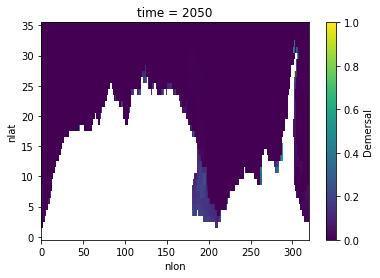

In [35]:
demersal_scaled.isel(time=100).plot()

### Load Emperor Penguin data

In [36]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/penguin/'

In [37]:
# load Emperor Penguin distances
file_in = 'CESM_grid_Emperor_individual_access_future.nc'
ds_ep = xr.open_dataset(path_in+file_in, decode_times=True)

total_ep = ds_ep.total_penguins

In [38]:
# cut years we don't need
total_ep = total_ep.where(total_ep.time >= 1950, drop=True)
total_ep = total_ep.where(total_ep.time < 2100, drop=True)

In [39]:
# scale this yearly data by maximum value in whole domain
data = total_ep
scale_value = data.max(dim=['nlat','nlon'])
ep_scaled = data/scale_value

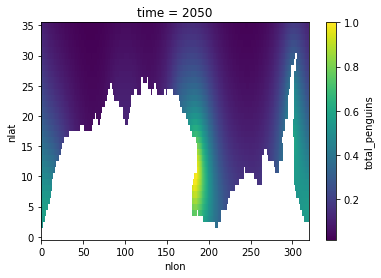

In [40]:
ep_scaled.isel(time=100).plot()

### Load Adelie Penguin data

In [41]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/penguin/'

In [42]:
# load Emperor Penguin distances
file_in = 'CESM_grid_Adelie_individual_access_future.nc'
ds_ap = xr.open_dataset(path_in+file_in, decode_times=True)

total_ap = ds_ap.total_penguins

In [43]:
# cut years we don't need
total_ap = total_ap.where(total_ap.time >= 1950, drop=True)
total_ap = total_ap.where(total_ap.time < 2100, drop=True)

In [44]:
# scale this yearly data by maximum value in whole domain
data = total_ap
scale_value = data.max(dim=['nlat','nlon'])
ap_scaled = data/scale_value

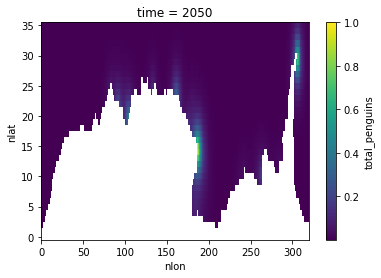

In [45]:
ap_scaled.isel(time=100).plot()

## Make Yearly ecoindex
- Calculate ecoindex by summing all inputs

In [46]:
# sum all inputs
ecoind_raw = npp_scaled + kgp_scaled + demersal_scaled + ep_scaled + ap_scaled

## Calculate fractional contribution of each input

In [47]:
# calculate fractional contribution of each species at each point
npp_frac = 100 * npp_scaled/ecoind_raw
kgp_frac = 100 * kgp_scaled/ecoind_raw
dfp_frac = 100 * demersal_scaled/ecoind_raw
ep_frac = 100 * ep_scaled/ecoind_raw
ap_frac = 100 * ap_scaled/ecoind_raw

In [48]:
# make an array of all the fractional contributions
aev_cont_frac = xr.concat((npp_frac, kgp_frac, dfp_frac, ep_frac, ap_frac),
                          dim='component')

# mask where it's not in the SIZ
aev_cont_frac = aev_cont_frac.where(sic_ens_mean >=0.15)

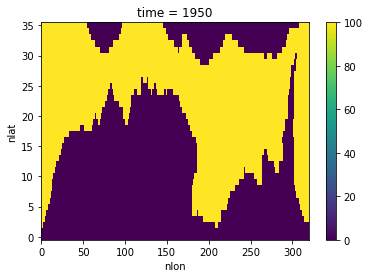

In [49]:
# verify that the fractional contribution sums to 100 at each time
aev_cont_frac.isel(time=0).sum(dim='component').plot()

## Make decadal means
- Calculate decadal index values by averaging 5 years around the decade (e.g. 1980 --> 1978, 1979, 1980, 1981, 1982)
- Also calculate decadal SIZ masks so we can use these for masking

In [50]:
# specify some arrays that will become coordinate arrays
decades = list(range(1960,2100,10))
decade_names = ['1960','1970','1980','1990','2000','2010','2020','2030','2040','2050','2060','2070','2080','2090']

In [51]:
# get dimensions of the grid we need to iterate over
xlen = len(ecoind_raw.nlon)
ylen = len(ecoind_raw.nlat)
dlen = len(decades)
clen = len(aev_cont_frac.component)
print(xlen,ylen,dlen,clen)

320 36 14 5


In [52]:
aev_cont_frac

<xarray.DataArray (component: 5, time: 150, nlat: 36, nlon: 320)>
dask.array<where, shape=(5, 150, 36, 320), dtype=float64, chunksize=(1, 150, 36, 320), chunktype=numpy.ndarray>
Coordinates:
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * time     (time) int64 1950 1951 1952 1953 1954 ... 2095 2096 2097 2098 2099
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -60.52 -60.52 -60.52
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 317.8 318.9 320.0
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -60.25 -60.25 -60.25
    TAREA    (nlat, nlon) float64 1.125e+13 1.125e+13 ... 3.656e+13 3.656e+13
Dimensions without coordinates: component

In [53]:
# Loop through decades

# make numpy array to fill and specify dimensions
array_decadal_regional = np.zeros([dlen,clen,ylen,xlen])

for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 1960:
        count = 0
    else: 
        count = count+1    
    # set the start and end years for this decade
    yy_st = dec - 2
    yy_ed = dec +3
    yy = list(range(yy_st,yy_ed,1)) 
    # subset the hemispheric data for these years only and get mean
    temp = aev_cont_frac.isel(time=aev_cont_frac.time.isin([yy]))
    array_decadal_regional[count,:,:,:] = temp.mean(dim='time')

# convert to xarray
aev_frac_decadal = xr.DataArray(array_decadal_regional,dims=('decades','component','nlat','nlon'))
aev_frac_decadal['decades'] = decades
aev_frac_decadal['nlat'] = ecoind_raw.nlat
aev_frac_decadal['nlon'] = ecoind_raw.nlon

Calculating decadal means for 1960s
Calculating decadal means for 1970s
Calculating decadal means for 1980s
Calculating decadal means for 1990s
Calculating decadal means for 2000s
Calculating decadal means for 2010s
Calculating decadal means for 2020s
Calculating decadal means for 2030s
Calculating decadal means for 2040s
Calculating decadal means for 2050s
Calculating decadal means for 2060s
Calculating decadal means for 2070s
Calculating decadal means for 2080s
Calculating decadal means for 2090s


## Find which input dominates at each point 

In [54]:
#  make temporary array with only ones for masks
#mask_ones = np.ones([dlen,len(ds_grid.TLAT.nlat),len(ds_grid.TLAT.nlon)])
mask_ones = np.ones([dlen,ylen,xlen])
mask_ones = xr.DataArray(mask_ones,dims=('decades','nlat','nlon'))
mask_ones['decades'] = decades
mask_ones['nlat'] = ds_grid.TLAT.nlat
mask_ones['nlon'] = ds_grid.TLAT.nlon

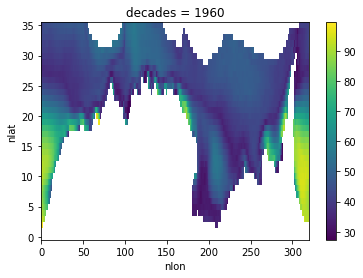

In [55]:
# make array of the highest value
frac_max = aev_frac_decadal.max(dim='component')
frac_max.isel(decades=0).plot()

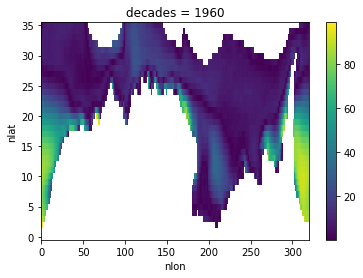

In [56]:
# find the difference between maximum fraction and next closest variable (are any less than 10% different?)

# Calculate differences
diff = frac_max - aev_frac_decadal

# mask any differences that are zero (that is just the component that contributed most)
diff = diff.where(diff > 0)

# find minimum difference - this is the next biggest contributor to the AEV
diff_min = diff.min(dim='component')

diff_min.isel(decades=0).plot()

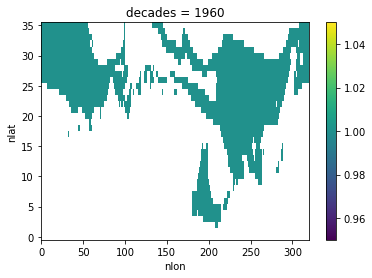

In [57]:
# create mask of the points where the minimum difference is 10%  or less
diff_pct_10 = mask_ones.where(diff_min <= 10.0)

diff_pct_10.isel(decades=0).plot()

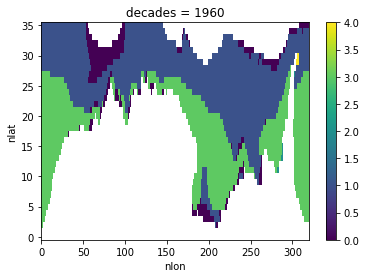

In [58]:
# find which species is maximum - dominates the index fractional contribution at each point 
# returns a mask where 0 = NPP, 1 = KGP, 2 = DFP, 3 = EP, 4 = AP
species = aev_frac_decadal.argmax(dim='component', skipna=False)

# mask where we don't have an AEV
species = species.where(frac_max >1)
species.isel(decades=0).plot()

## Plot figures

In [59]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [60]:
# get colony distance info for plotting
lons = ds_grid.TLONG
lats = ds_grid.TLAT

In [61]:
# make arrays for the Amundsen/Peninsula region
lats_bound = np.arange(-73, -50, 1)
#lats_bound
lons_bound = np.linspace(275, 275, lats_bound.shape[0])
#lons_bound

In [62]:
# mask the land
aev_frac_decadal = aev_frac_decadal.where(ds_grid.REGION_MASK == 1)
frac_max = frac_max.where(ds_grid.REGION_MASK == 1)
diff_pct_10 = diff_pct_10.where(ds_grid.REGION_MASK == 1)
species = species.where(ds_grid.REGION_MASK == 1)

### Set plotting ranges, etc.

In [63]:
# set some plotting info
# colors for individual contributions
cmap_in = cmocean.cm.rain
vmin_in = 0.0
vmax_in = 100.0

# make colormap for species map
from matplotlib.colors import ListedColormap
cmap_species = ListedColormap(name='species_cats', colors=['forestgreen','firebrick', 'gold','rebeccapurple','deepskyblue'])

# contour levels for "valuable" area
levels_in_ctr = np.arange(0,3,1)

### Save plot

In [64]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_6/'

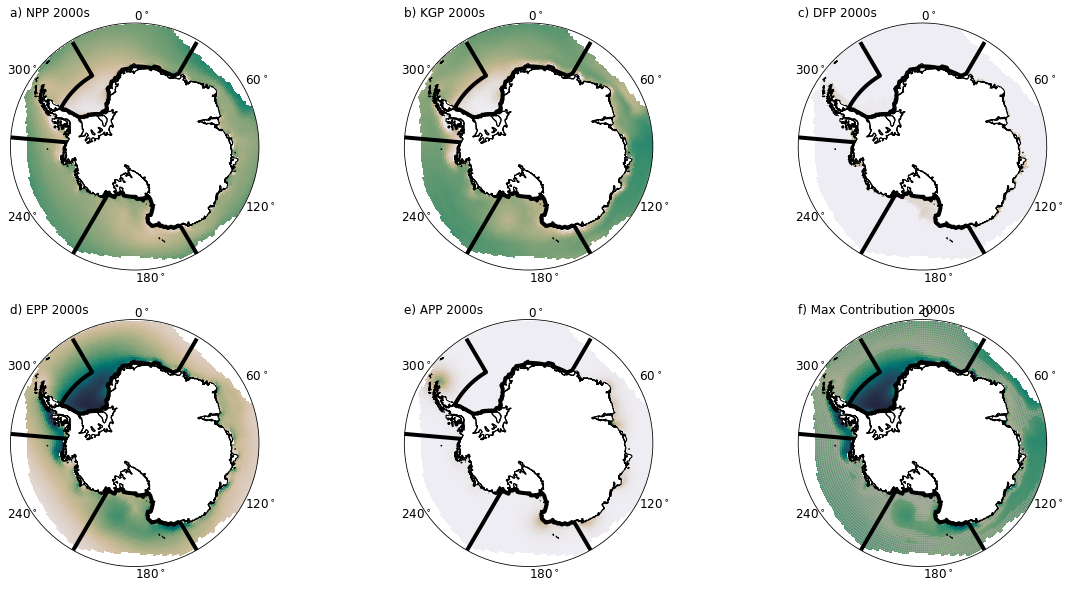

In [65]:
# Plot 2000s
dec = 2000

# create figure
fig = plt.figure(figsize=(20,10))
fout = 'SFigure_AEV_contribution_'+str(dec)

lab1 = 'a) NPP '+str(dec)+'s'
lab2 = 'b) KGP '+str(dec)+'s'
lab3 = 'c) DFP '+str(dec)+'s'
lab4 = 'd) EPP '+str(dec)+'s'
lab5 = 'e) APP '+str(dec)+'s'
lab6 = 'f) Max Contribution '+str(dec)+'s'
        
## Plot individual data ## - # plot the region as subplots - note it's nrow x ncol x index (starting upper left)
### Plot NPP fractional contribution
ax = fig.add_subplot(2,3,1, projection = ccrs.SouthPolarStereo())
ax.set_title(lab1, loc='left')
lon, lat, field = utils.adjust_pop_grid(lons,lats,aev_frac_decadal.isel(component=0).sel(decades=dec))
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot KGP fractional contribution
ax = fig.add_subplot(2,3,2, projection = ccrs.SouthPolarStereo())
ax.set_title(lab2, loc='left')
lon, lat, field = utils.adjust_pop_grid(lons,lats,aev_frac_decadal.isel(component=1).sel(decades=dec))
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot DFP fractional contribution
ax = fig.add_subplot(2,3,3, projection = ccrs.SouthPolarStereo())
ax.set_title(lab3, loc='left')
lon, lat, field = utils.adjust_pop_grid(lons,lats,aev_frac_decadal.isel(component=2).sel(decades=dec))
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot EP fractional contribution
ax = fig.add_subplot(2,3,4, projection = ccrs.SouthPolarStereo())
ax.set_title(lab4, loc='left')
lon, lat, field = utils.adjust_pop_grid(lons,lats,aev_frac_decadal.isel(component=3).sel(decades=dec))
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot AP fractional contribution
ax = fig.add_subplot(2,3,5, projection = ccrs.SouthPolarStereo())
ax.set_title(lab5, loc='left')
lon, lat, field = utils.adjust_pop_grid(lons,lats,aev_frac_decadal.isel(component=4).sel(decades=dec))
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot Maximum fractional contribution
ax = fig.add_subplot(2,3,6, projection = ccrs.SouthPolarStereo())
ax.set_title(lab6, loc='left')
lon, lat, field = utils.adjust_pop_grid(lons,lats,frac_max.sel(decades=dec))
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
### Overlay dots where values are < 10% different from next nearest contribution 
lon, lat, field = utils.adjust_pop_grid(lons,lats,diff_pct_10.sel(decades=dec))
this1 = ax.scatter(lon, lat,
                   field,
                   color='darkgrey', marker='.', linewidths=1,
                   transform=ccrs.PlateCarree())
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

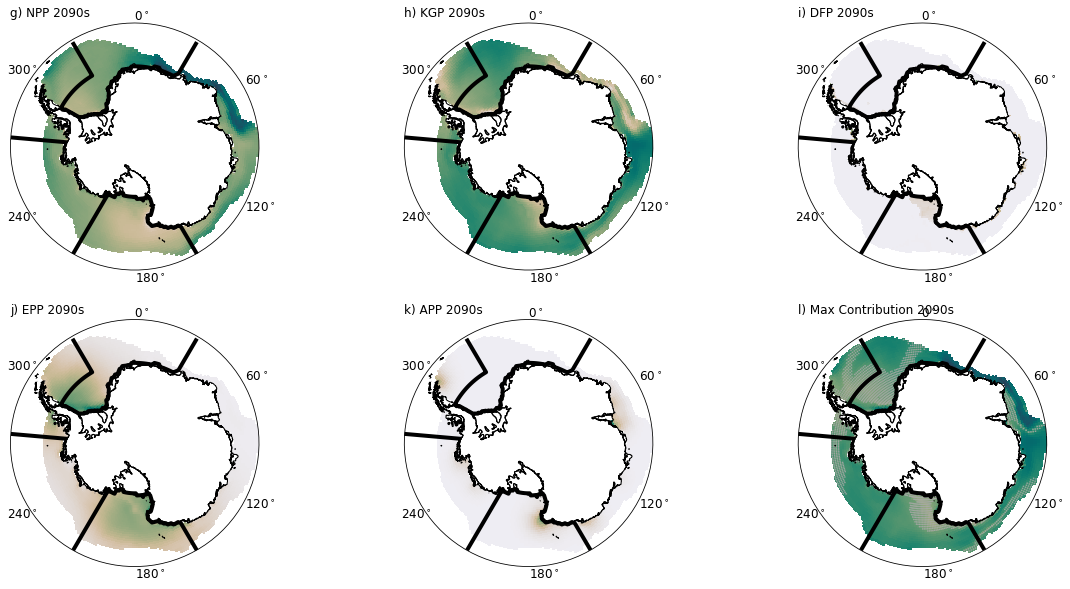

In [66]:
# Plot 20090s
dec = 2090

# create figure
fig = plt.figure(figsize=(20,10))
fout = 'SFigure_AEV_contribution_'+str(dec)

lab1 = 'g) NPP '+str(dec)+'s'
lab2 = 'h) KGP '+str(dec)+'s'
lab3 = 'i) DFP '+str(dec)+'s'
lab4 = 'j) EPP '+str(dec)+'s'
lab5 = 'k) APP '+str(dec)+'s'
lab6 = 'l) Max Contribution '+str(dec)+'s'
        
## Plot individual data ## - # plot the region as subplots - note it's nrow x ncol x index (starting upper left)
### Plot NPP fractional contribution
ax = fig.add_subplot(2,3,1, projection = ccrs.SouthPolarStereo())
ax.set_title(lab1, loc='left')
lon, lat, field = utils.adjust_pop_grid(lons,lats,aev_frac_decadal.isel(component=0).sel(decades=dec))
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot KGP fractional contribution
ax = fig.add_subplot(2,3,2, projection = ccrs.SouthPolarStereo())
ax.set_title(lab2, loc='left')
lon, lat, field = utils.adjust_pop_grid(lons,lats,aev_frac_decadal.isel(component=1).sel(decades=dec))
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot DFP fractional contribution
ax = fig.add_subplot(2,3,3, projection = ccrs.SouthPolarStereo())
ax.set_title(lab3, loc='left')
lon, lat, field = utils.adjust_pop_grid(lons,lats,aev_frac_decadal.isel(component=2).sel(decades=dec))
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot EP fractional contribution
ax = fig.add_subplot(2,3,4, projection = ccrs.SouthPolarStereo())
ax.set_title(lab4, loc='left')
lon, lat, field = utils.adjust_pop_grid(lons,lats,aev_frac_decadal.isel(component=3).sel(decades=dec))
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot AP fractional contribution
ax = fig.add_subplot(2,3,5, projection = ccrs.SouthPolarStereo())
ax.set_title(lab5, loc='left')
lon, lat, field = utils.adjust_pop_grid(lons,lats,aev_frac_decadal.isel(component=4).sel(decades=dec))
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot Maximum fractional contribution
ax = fig.add_subplot(2,3,6, projection = ccrs.SouthPolarStereo())
ax.set_title(lab6, loc='left')
lon, lat, field = utils.adjust_pop_grid(lons,lats,frac_max.sel(decades=dec))
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
### Overlay dots where values are < 10% different from next nearest contribution 
lon, lat, field = utils.adjust_pop_grid(lons,lats,diff_pct_10.sel(decades=dec))
this1 = ax.scatter(lon, lat,
                   field,
                   color='darkgrey', marker='.', linewidths=1,
                   transform=ccrs.PlateCarree())
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

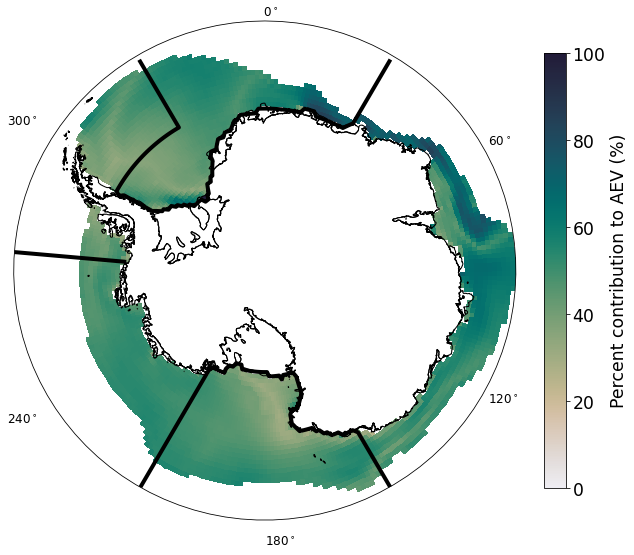

In [67]:
# Plot
# create figure
fig = plt.figure(figsize=(10,10))
fout = 'SFigure_AEV_contribution_colorbar'
        
## Plot individual data ## - # plot the region as subplots - note it's nrow x ncol x index (starting upper left)
### Plot NPP fractional contribution
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
lon, lat, field = utils.adjust_pop_grid(lons,lats,frac_max.sel(decades=dec))
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='vertical',extend='neither',fraction=0.05,pad=0.05,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_ylabel('Percent contribution to AEV (%)',fontsize='xx-large')

### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

Text(0.25, 0.91, 'a) 2000s')

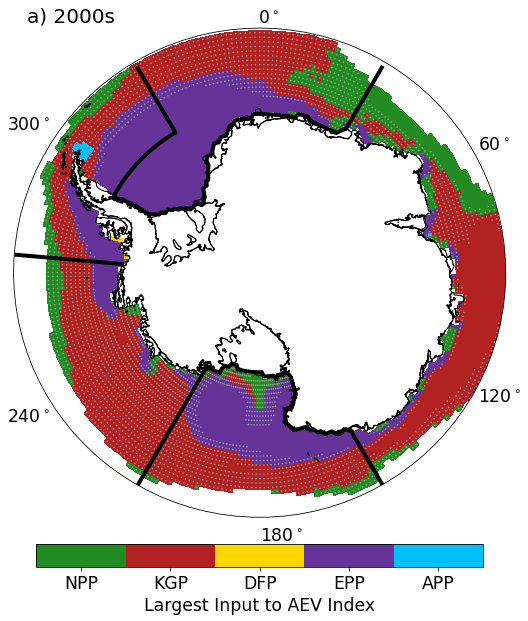

In [68]:
# Plot - 2000s
dec = 2000

# create figure
fig = plt.figure(figsize=(10,10))
fout = 'Figure_5_input_fractions_'+str(dec)

# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot Dominant Species Info
lon, lat, field = utils.adjust_pop_grid(lons,lats,species.sel(decades=dec))
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_species,                      
                     vmax=4, vmin=0,
                     transform=ccrs.PlateCarree())

tk = np.arange(0.4, 4, 0.8)
cbar = ax.figure.colorbar(this,ticks=tk, orientation='horizontal',extend='neither',fraction=0.05,pad=0.05,shrink=0.8,)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel(r'Largest Input to AEV Index',fontsize='xx-large')
cbar.ax.set_xticklabels(['NPP','KGP','DFP','EPP','APP'], fontsize='xx-large')

### Overlay dots where values are < 10% different from next nearest contribution 
lon, lat, field = utils.adjust_pop_grid(lons,lats,diff_pct_10.sel(decades=dec))
this1 = ax.scatter(lon, lat,
                   field,
                   color='darkgrey', marker='.', linewidths=1,
                   transform=ccrs.PlateCarree())

### Overlay valuable areas - too noisy, remove
#lon, lat, field = utils.adjust_pop_grid(lons,lats,aev_high.fillna(0))
#this2=ax.contour(lon,lat,field,
#                 colors='grey',linestyles='solid',linewidths=3,
#                 levels=levels_in_ctr,
#                 transform=ccrs.PlateCarree()) 

### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
fig.suptitle('a) 2000s',fontsize=20, x=0.25, y=0.91)  
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

Text(0.25, 0.91, 'b) 2090s')

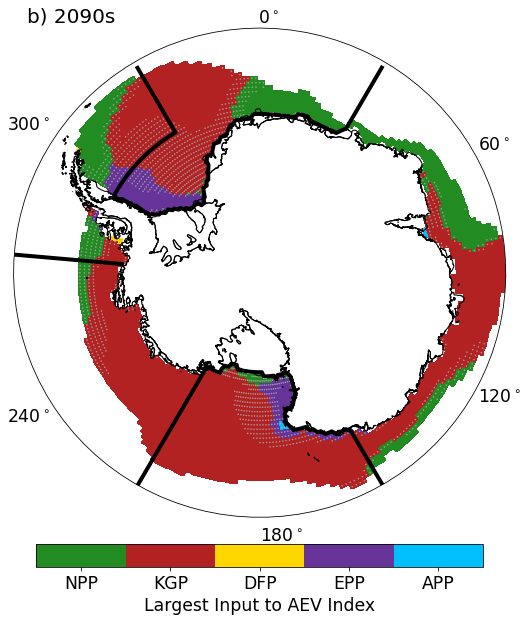

In [69]:
# Plot - 2090s
dec = 2090

# create figure
fig = plt.figure(figsize=(10,10))
fout = 'Figure_5_input_fractions_'+str(dec)

# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot Dominant Species Info
lon, lat, field = utils.adjust_pop_grid(lons,lats,species.sel(decades=dec))
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_species,                      
                     vmax=4, vmin=0,
                     transform=ccrs.PlateCarree())

tk = np.arange(0.4, 4, 0.8)
cbar = ax.figure.colorbar(this,ticks=tk, orientation='horizontal',extend='neither',fraction=0.05,pad=0.05,shrink=0.8,)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel(r'Largest Input to AEV Index',fontsize='xx-large')
cbar.ax.set_xticklabels(['NPP','KGP','DFP','EPP','APP'], fontsize='xx-large')

### Overlay dots where values are < 10% different from next nearest contribution 
lon, lat, field = utils.adjust_pop_grid(lons,lats,diff_pct_10.sel(decades=dec))
this1 = ax.scatter(lon, lat,
                   field,
                   color='darkgrey', marker='.', linewidths=1,
                   transform=ccrs.PlateCarree())

### Overlay valuable areas - too noisy, remove
#lon, lat, field = utils.adjust_pop_grid(lons,lats,aev_high.fillna(0))
#this2=ax.contour(lon,lat,field,
#                 colors='grey',linestyles='solid',linewidths=3,
#                 levels=levels_in_ctr,
#                 transform=ccrs.PlateCarree()) 

### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
fig.suptitle('b) 2090s',fontsize=20, x=0.25, y=0.91)  
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)